In [67]:
# Imports
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score, make_scorer
from scipy.stats import ttest_rel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [40]:
# Read in the data
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/patient_churn_dataset.csv')
X = df.drop(df.columns[-1], axis=1)
y = df[df.columns[-1]]


# Show example rows
display(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PatientID  Age  Gender State  Tenure_Months          Specialty  \
0       C20000   41  Female    PA             62         Pediatrics   
1       C20001   43  Female    GA             44  Internal Medicine   
2       C20002   21    Male    MI            120  Internal Medicine   
3       C20003   65    Male    FL            118   General Practice   
4       C20004   18  Female    CA             70         Cardiology   
...        ...  ...     ...   ...            ...                ...   
1995    C21995   31    Male    NC             78  Internal Medicine   
1996    C21996   45  Female    GA             69  Internal Medicine   
1997    C21997   37    Male    NC             91    Family Medicine   
1998    C21998   69  Female    NY              5  Internal Medicine   
1999    C21999   63  Female    NC             69    Family Medicine   

     Insurance_Type  Visits_Last_Year  Missed_Appointments  \
0          Medicaid                 1                    0   
1          Self-Pay                 7                    4   
2          Medicaid                15                    5   
3           Private                10                    3   
4          Medicaid                 5                    4   
...             ...               ...                  ...   
1995       Medicare                 8                    2   
1996        Private                 6                    4   
1997       Medicare                 9                    4   
1998        Private                 3                    0   
1999        Private                 6                    2   

      Days_Since_Last_Visit  ... Overall_Satisfaction  Wait_Time_Satisfaction  \
0                       564  ...                  3.5                     4.9   
1                       254  ...                  2.6                     3.1   
2                        89  ...                  1.6                     4.4   
3                       135  ...                  2.6                     4.3   
4                       696  ...                  2.2                     4.0   
...                     ...  ...                  ...                     ...   
1995                    180  ...                  3.9                     1.8   
1996                    352  ...                  4.2                     2.8   
1997                    494  ...                  3.9                     2.7   
1998                    315  ...                  1.7                     3.2   
1999                    675  ...                  2.3                     3.4   

      Staff_Satisfaction  Provider_Rating  Avg_Out_Of_Pocket_Cost  \
0                    3.8              4.2                     306   
1                    4.7              4.3                    1851   
2                    2.1              4.7                     391   
3                    4.3              4.9                     808   
4                    4.1              4.4                     866   
...                  ...              ...                     ...   
1995                 2.4              2.9                     268   
1996                 3.5              4.6                    1257   
1997                 3.0              2.7                      50   
1998                 3.6              4.2                     848   
1999                 4.0              4.9                    1310   

      Billing_Issues  Portal_Usage  Referrals_Made  \
0                  0             0               3   
1                  0             0               0   
2                  0             0               2   
3                  0             0               0   
4                  0             0               0   
...              ...           ...             ...   
1995               0             1               0   
1996               1             0               3   
1997               0             1               3   
1998               0             0               1   
1999       

In [41]:
df.dtypes

PatientID                      object
Age                             int64
Gender                         object
State                          object
Tenure_Months                   int64
Specialty                      object
Insurance_Type                 object
Visits_Last_Year                int64
Missed_Appointments             int64
Days_Since_Last_Visit           int64
Last_Interaction_Date          object
Overall_Satisfaction          float64
Wait_Time_Satisfaction        float64
Staff_Satisfaction            float64
Provider_Rating               float64
Avg_Out_Of_Pocket_Cost          int64
Billing_Issues                  int64
Portal_Usage                    int64
Referrals_Made                  int64
Distance_To_Facility_Miles    float64
Churned                         int64
dtype: object

In [70]:
# Check for null values
display(df.isnull().sum())
# None should be missing

print("Num Unique Rows:", df.drop_duplicates().shape[0])
# No duplicates as everything has its own unique PatientID
# 2000 rows to start so since 2000 unique we do not have duplicates

PatientID                     0
Age                           0
Gender                        0
State                         0
Tenure_Months                 0
Specialty                     0
Insurance_Type                0
Visits_Last_Year              0
Missed_Appointments           0
Days_Since_Last_Visit         0
Last_Interaction_Date         0
Overall_Satisfaction          0
Wait_Time_Satisfaction        0
Staff_Satisfaction            0
Provider_Rating               0
Avg_Out_Of_Pocket_Cost        0
Billing_Issues                0
Portal_Usage                  0
Referrals_Made                0
Distance_To_Facility_Miles    0
Churned                       0
dtype: int64

Num Unique Rows: 2000


In [42]:
# Data Preprocessing (No standardization as trees do not care about scale)
# Drop last interaction date as it does not generalize well for future data. Drop PatientID as it can cause overfitting
X = X.drop(columns=['Last_Interaction_Date', 'PatientID'], errors='ignore')

# One hot encoding for categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas')
onehot_df = encoder.fit_transform(X[['Gender', 'State', 'Specialty', 'Insurance_Type']])

X = X.drop(columns=['Gender', 'State', 'Specialty', 'Insurance_Type'], axis=1)
X = pd.concat([X, onehot_df], axis=1)
display(X)

Age  Tenure_Months  Visits_Last_Year  Missed_Appointments  \
0      41             62                 1                    0   
1      43             44                 7                    4   
2      21            120                15                    5   
3      65            118                10                    3   
4      18             70                 5                    4   
...   ...            ...               ...                  ...   
1995   31             78                 8                    2   
1996   45             69                 6                    4   
1997   37             91                 9                    4   
1998   69              5                 3                    0   
1999   63             69                 6                    2   

      Days_Since_Last_Visit  Overall_Satisfaction  Wait_Time_Satisfaction  \
0                       564                   3.5                     4.9   
1                       254                   2.6                     3.1   
2                        89                   1.6                     4.4   
3                       135                   2.6                     4.3   
4                       696                   2.2                     4.0   
...                     ...                   ...                     ...   
1995                    180                   3.9                     1.8   
1996                    352                   4.2                     2.8   
1997                    494                   3.9                     2.7   
1998                    315                   1.7                     3.2   
1999                    675                   2.3                     3.4   

      Staff_Satisfaction  Provider_Rating  Avg_Out_Of_Pocket_Cost  ...  \
0                    3.8              4.2                     306  ...   
1                    4.7              4.3                    1851  ...   
2                    2.1              4.7                     391  ...   
3                    4.3              4.9                     808  ...   
4                    4.1              4.4                     866  ...   
...                  ...              ...                     ...  ...   
1995                 2.4              2.9                     268  ...   
1996                 3.5              4.6                    1257  ...   
1997                 3.0              2.7                      50  ...   
1998                 3.6              4.2                     848  ...   
1999                 4.0              4.9                    1310  ...   

      Specialty_Family Medicine  Specialty_General Practice  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         1.0   
4                           0.0                         0.0   
...                         ...                         ...   
1995                        0.0                         0.0   
1996                        0.0                         0.0   
1997                        1.0                         0.0   
1998                        0.0                         0.0   
1999                        1.0                         0.0   

      Specialty_Internal Medicine  Specialty_Neurology  Specialty_Orthopedics  \
0                             0.0                  0.0                    0.0   
1                             1.0                  0.0                    0.0   
2                             1.0                  0.0                    0.0   
3                             0.0                  0.0                    0.0   
4                             0.0                  0.0                    0.0   
...                           ...                  ...                    ...   
1995                          1.0                  0.0         

In [43]:
# Check that we only have int/float features now
X.dtypes

Age                              int64
Tenure_Months                    int64
Visits_Last_Year                 int64
Missed_Appointments              int64
Days_Since_Last_Visit            int64
Overall_Satisfaction           float64
Wait_Time_Satisfaction         float64
Staff_Satisfaction             float64
Provider_Rating                float64
Avg_Out_Of_Pocket_Cost           int64
Billing_Issues                   int64
Portal_Usage                     int64
Referrals_Made                   int64
Distance_To_Facility_Miles     float64
Gender_Female                  float64
Gender_Male                    float64
State_CA                       float64
State_FL                       float64
State_GA                       float64
State_IL                       float64
State_MI                       float64
State_NC                       float64
State_NY                       float64
State_OH                       float64
State_PA                       float64
State_TX                       float64
Specialty_Cardiology           float64
Specialty_Family Medicine      float64
Specialty_General Practice     float64
Specialty_Internal Medicine    float64
Specialty_Neurology            float64
Specialty_Orthopedics          float64
Specialty_Pediatrics           float64
Insurance_Type_Medicaid        float64
Insurance_Type_Medicare        float64
Insurance_Type_Private         float64
Insurance_Type_Self-Pay        float64
dtype: object

# Task 1 (30 points): Implement a Decision Tree Classifier for your classification problem. You may use a built-in package to implement your classifier. Additionally, do the following:


• Visualize the decision tree structure for at least three different parameter settings.
Comment on how the depth and complexity change the tree.


• Do some research on what sensitivity analysis is and how it is performed (include
citations). Perform a sensitivity analysis to measure the impact of at least two input
features on your model's decision boundary.


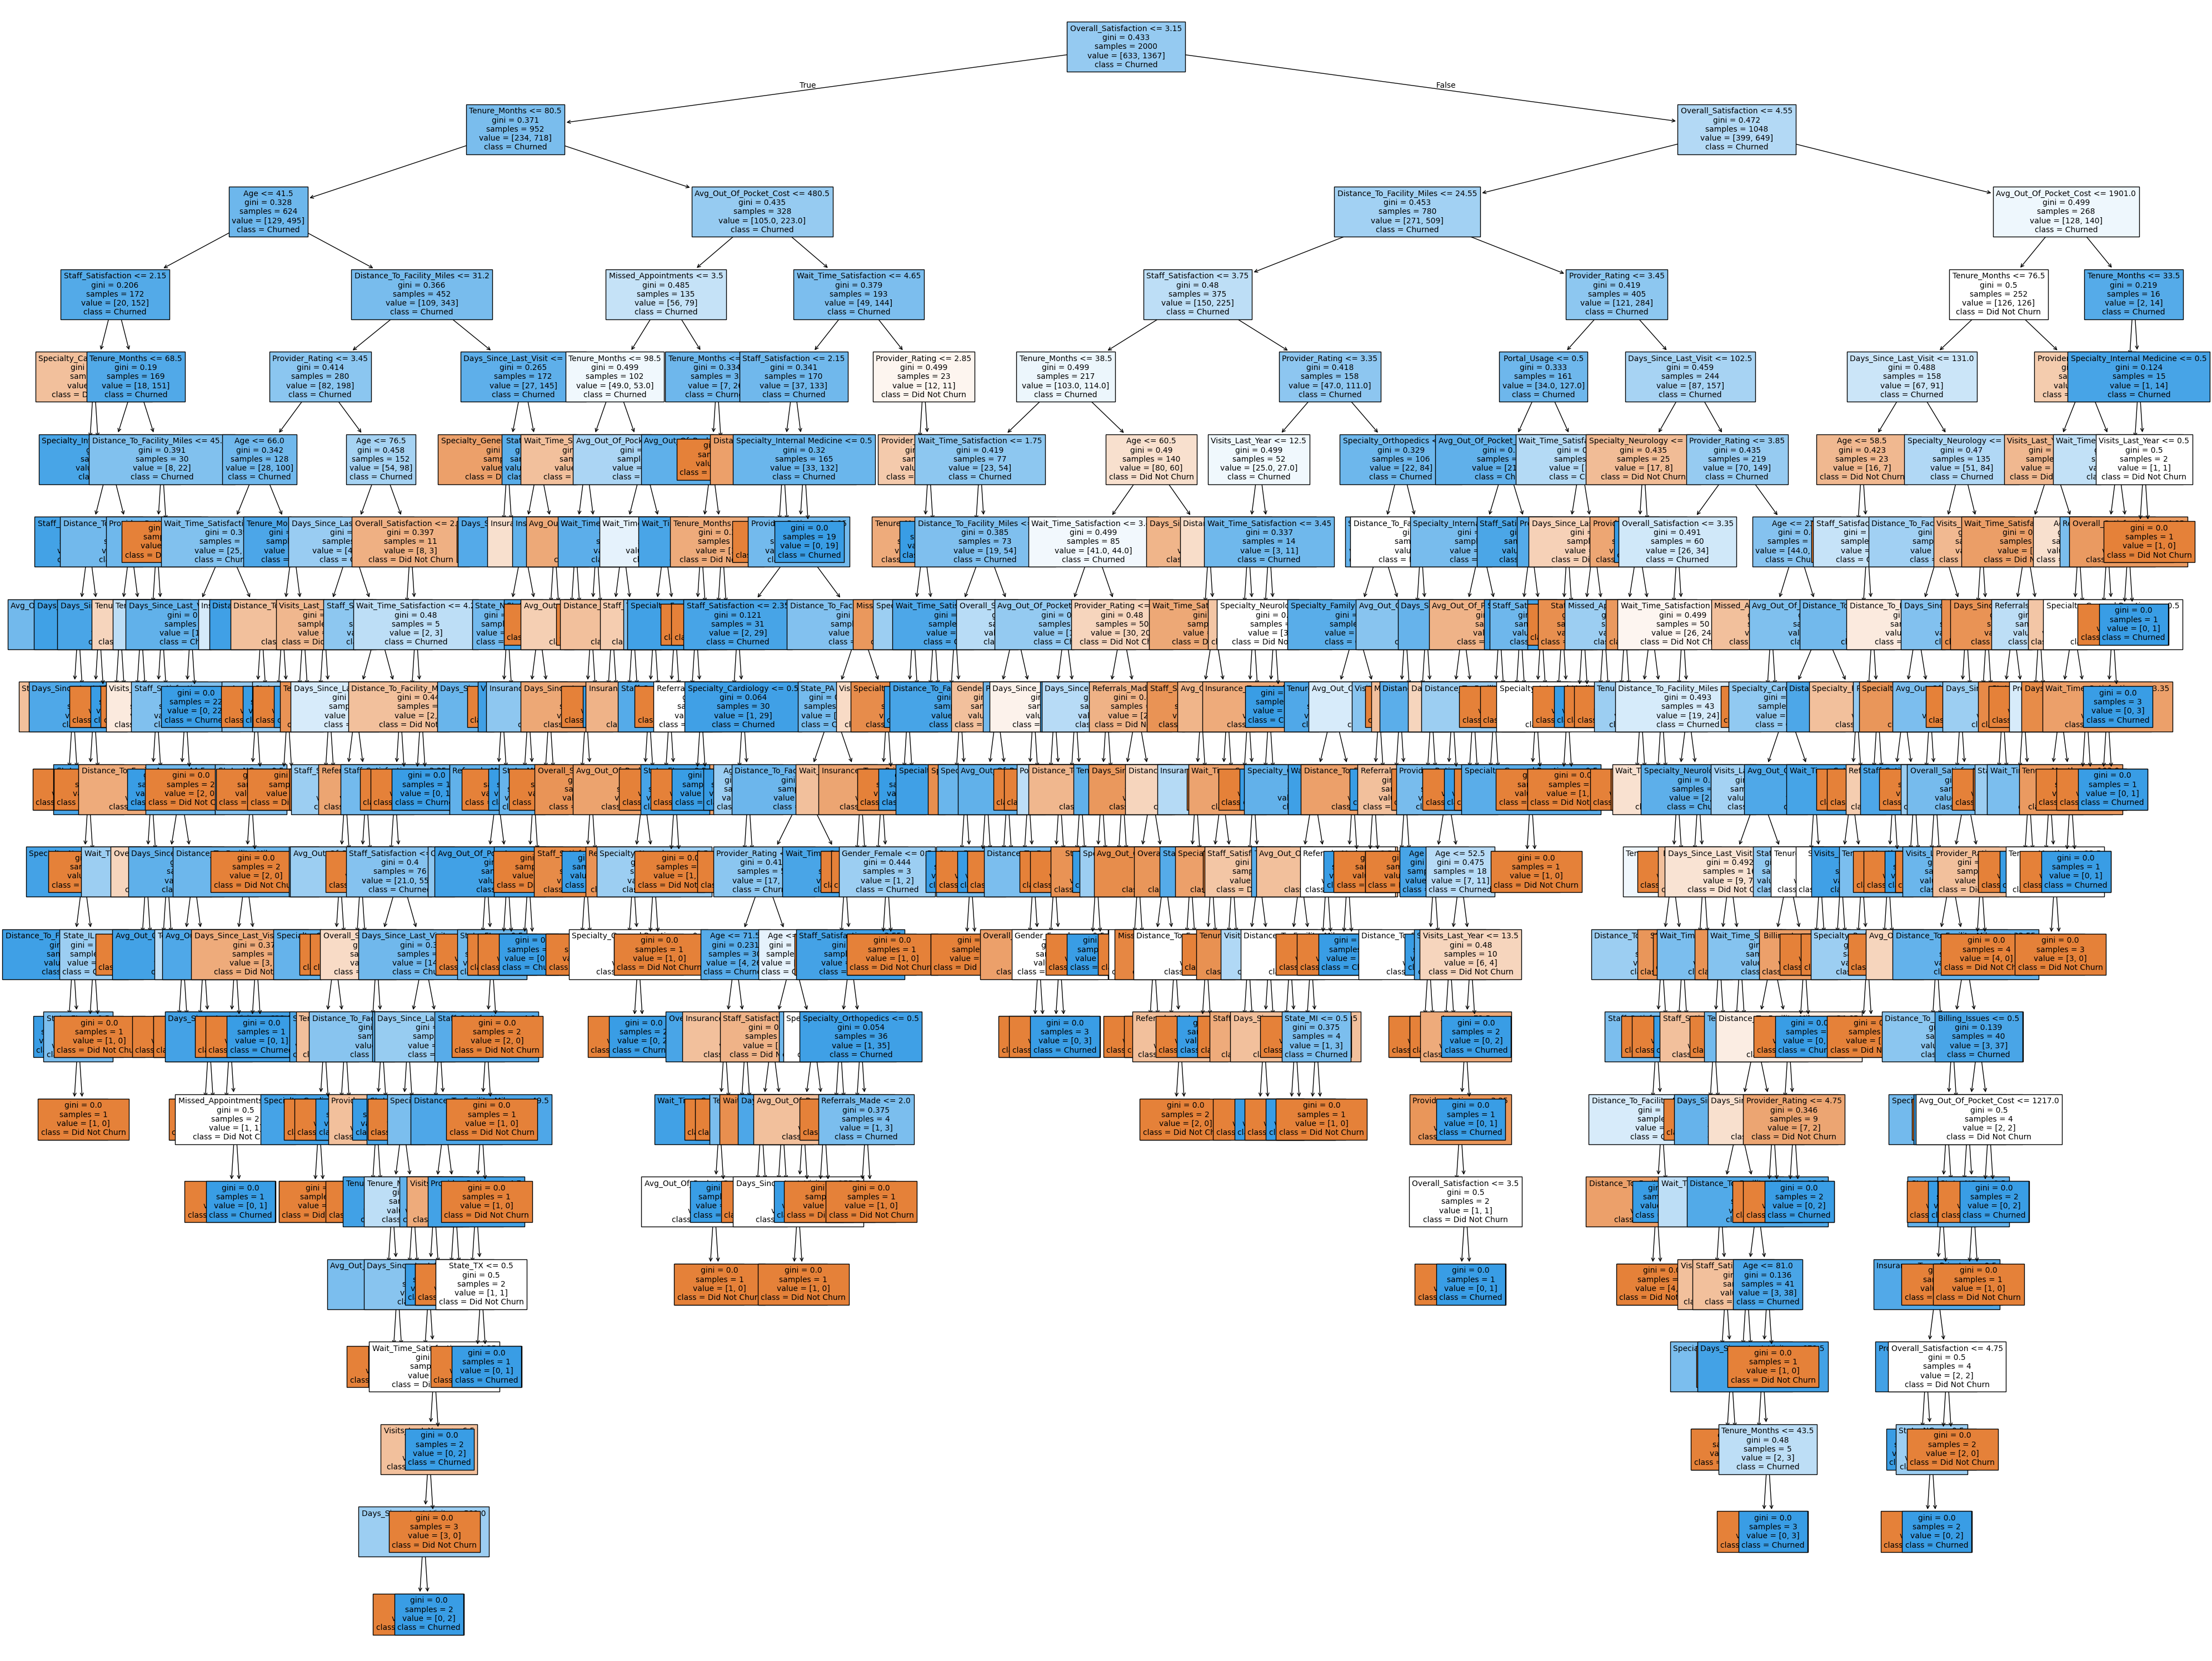

In [44]:
# Display the basic decision tree classifier with no change to any of its hyper parameters
dt1 = DecisionTreeClassifier(random_state=9)
dt1.fit(X, y)

# Display the Tree
plt.figure("Decision Tree", figsize=(40,30))
plot_tree(dt1, fontsize=10, filled=True, feature_names=X.columns, class_names=["Did Not Churn", "Churned"])
plt.tight_layout()
plt.show()



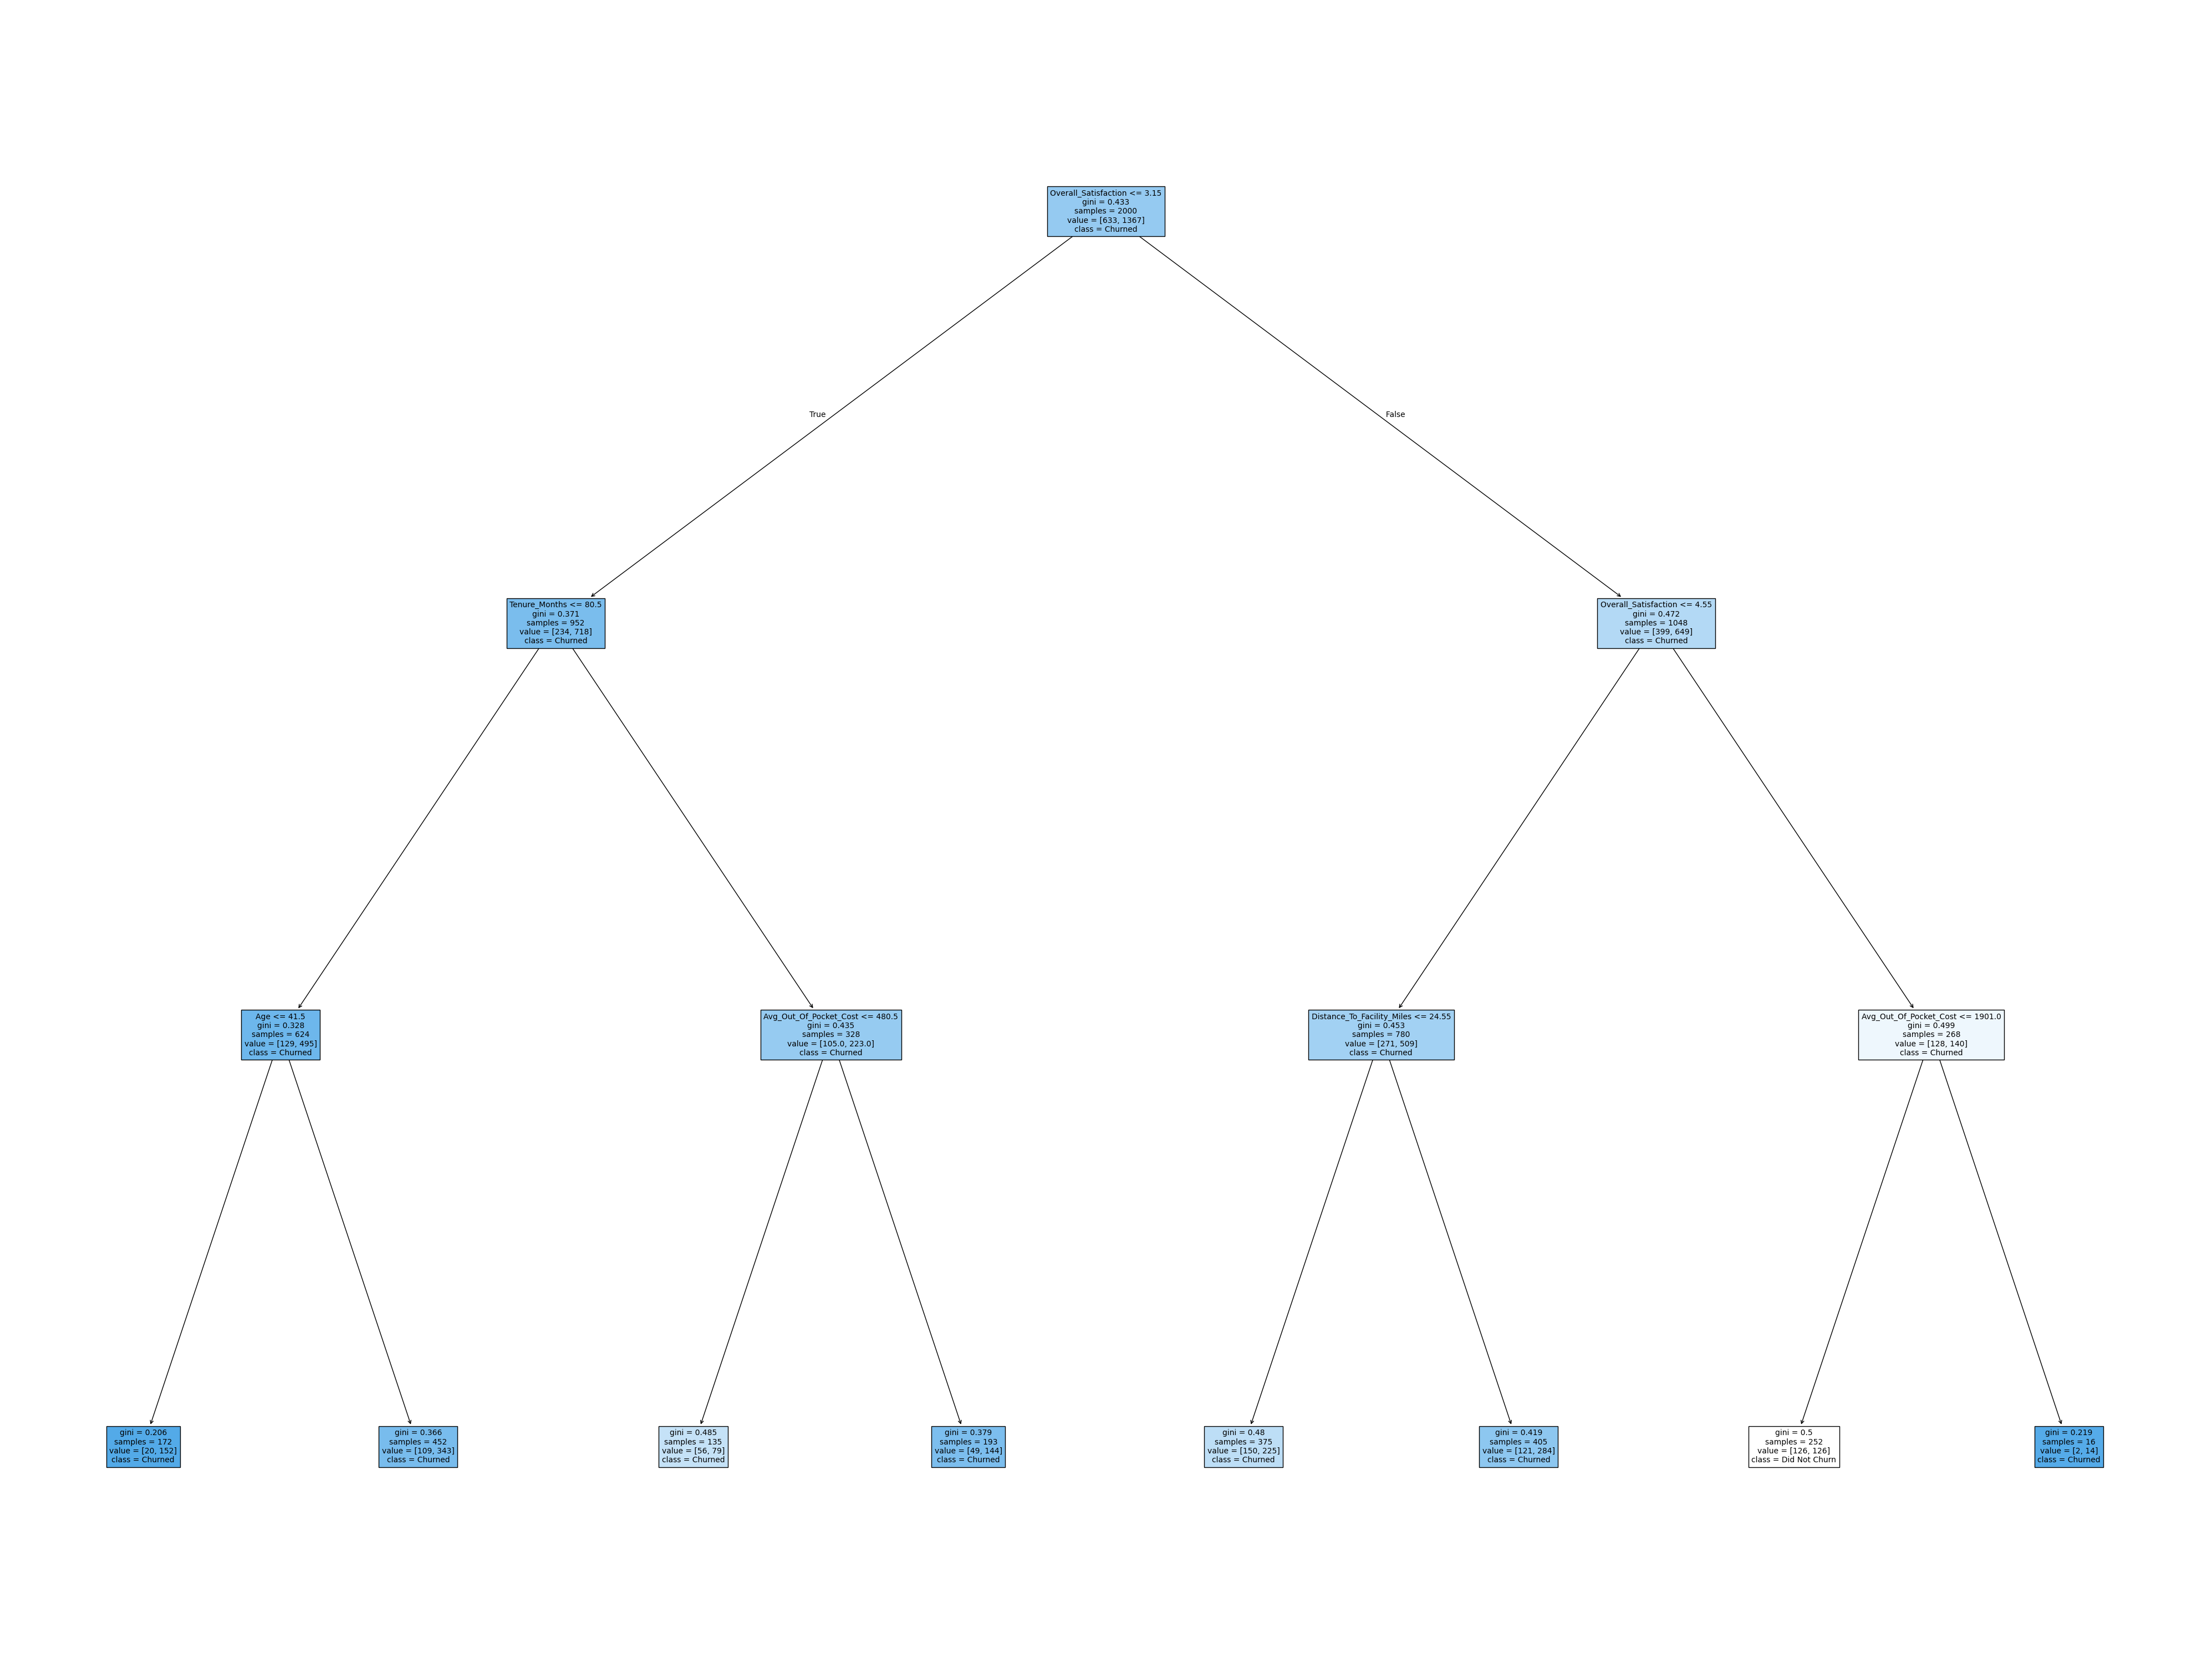

In [45]:
# Display with a low max depth tree (one that underfits)
# By having low depth there isnt enough to learn anything real
dt2 = DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=9)
dt2.fit(X, y)

# Display the Tree
plt.figure("Decision Tree", figsize=(40,30))
plot_tree(dt2, fontsize=10, filled=True, feature_names=X.columns, class_names=["Did Not Churn", "Churned"])
plt.tight_layout()
plt.show()

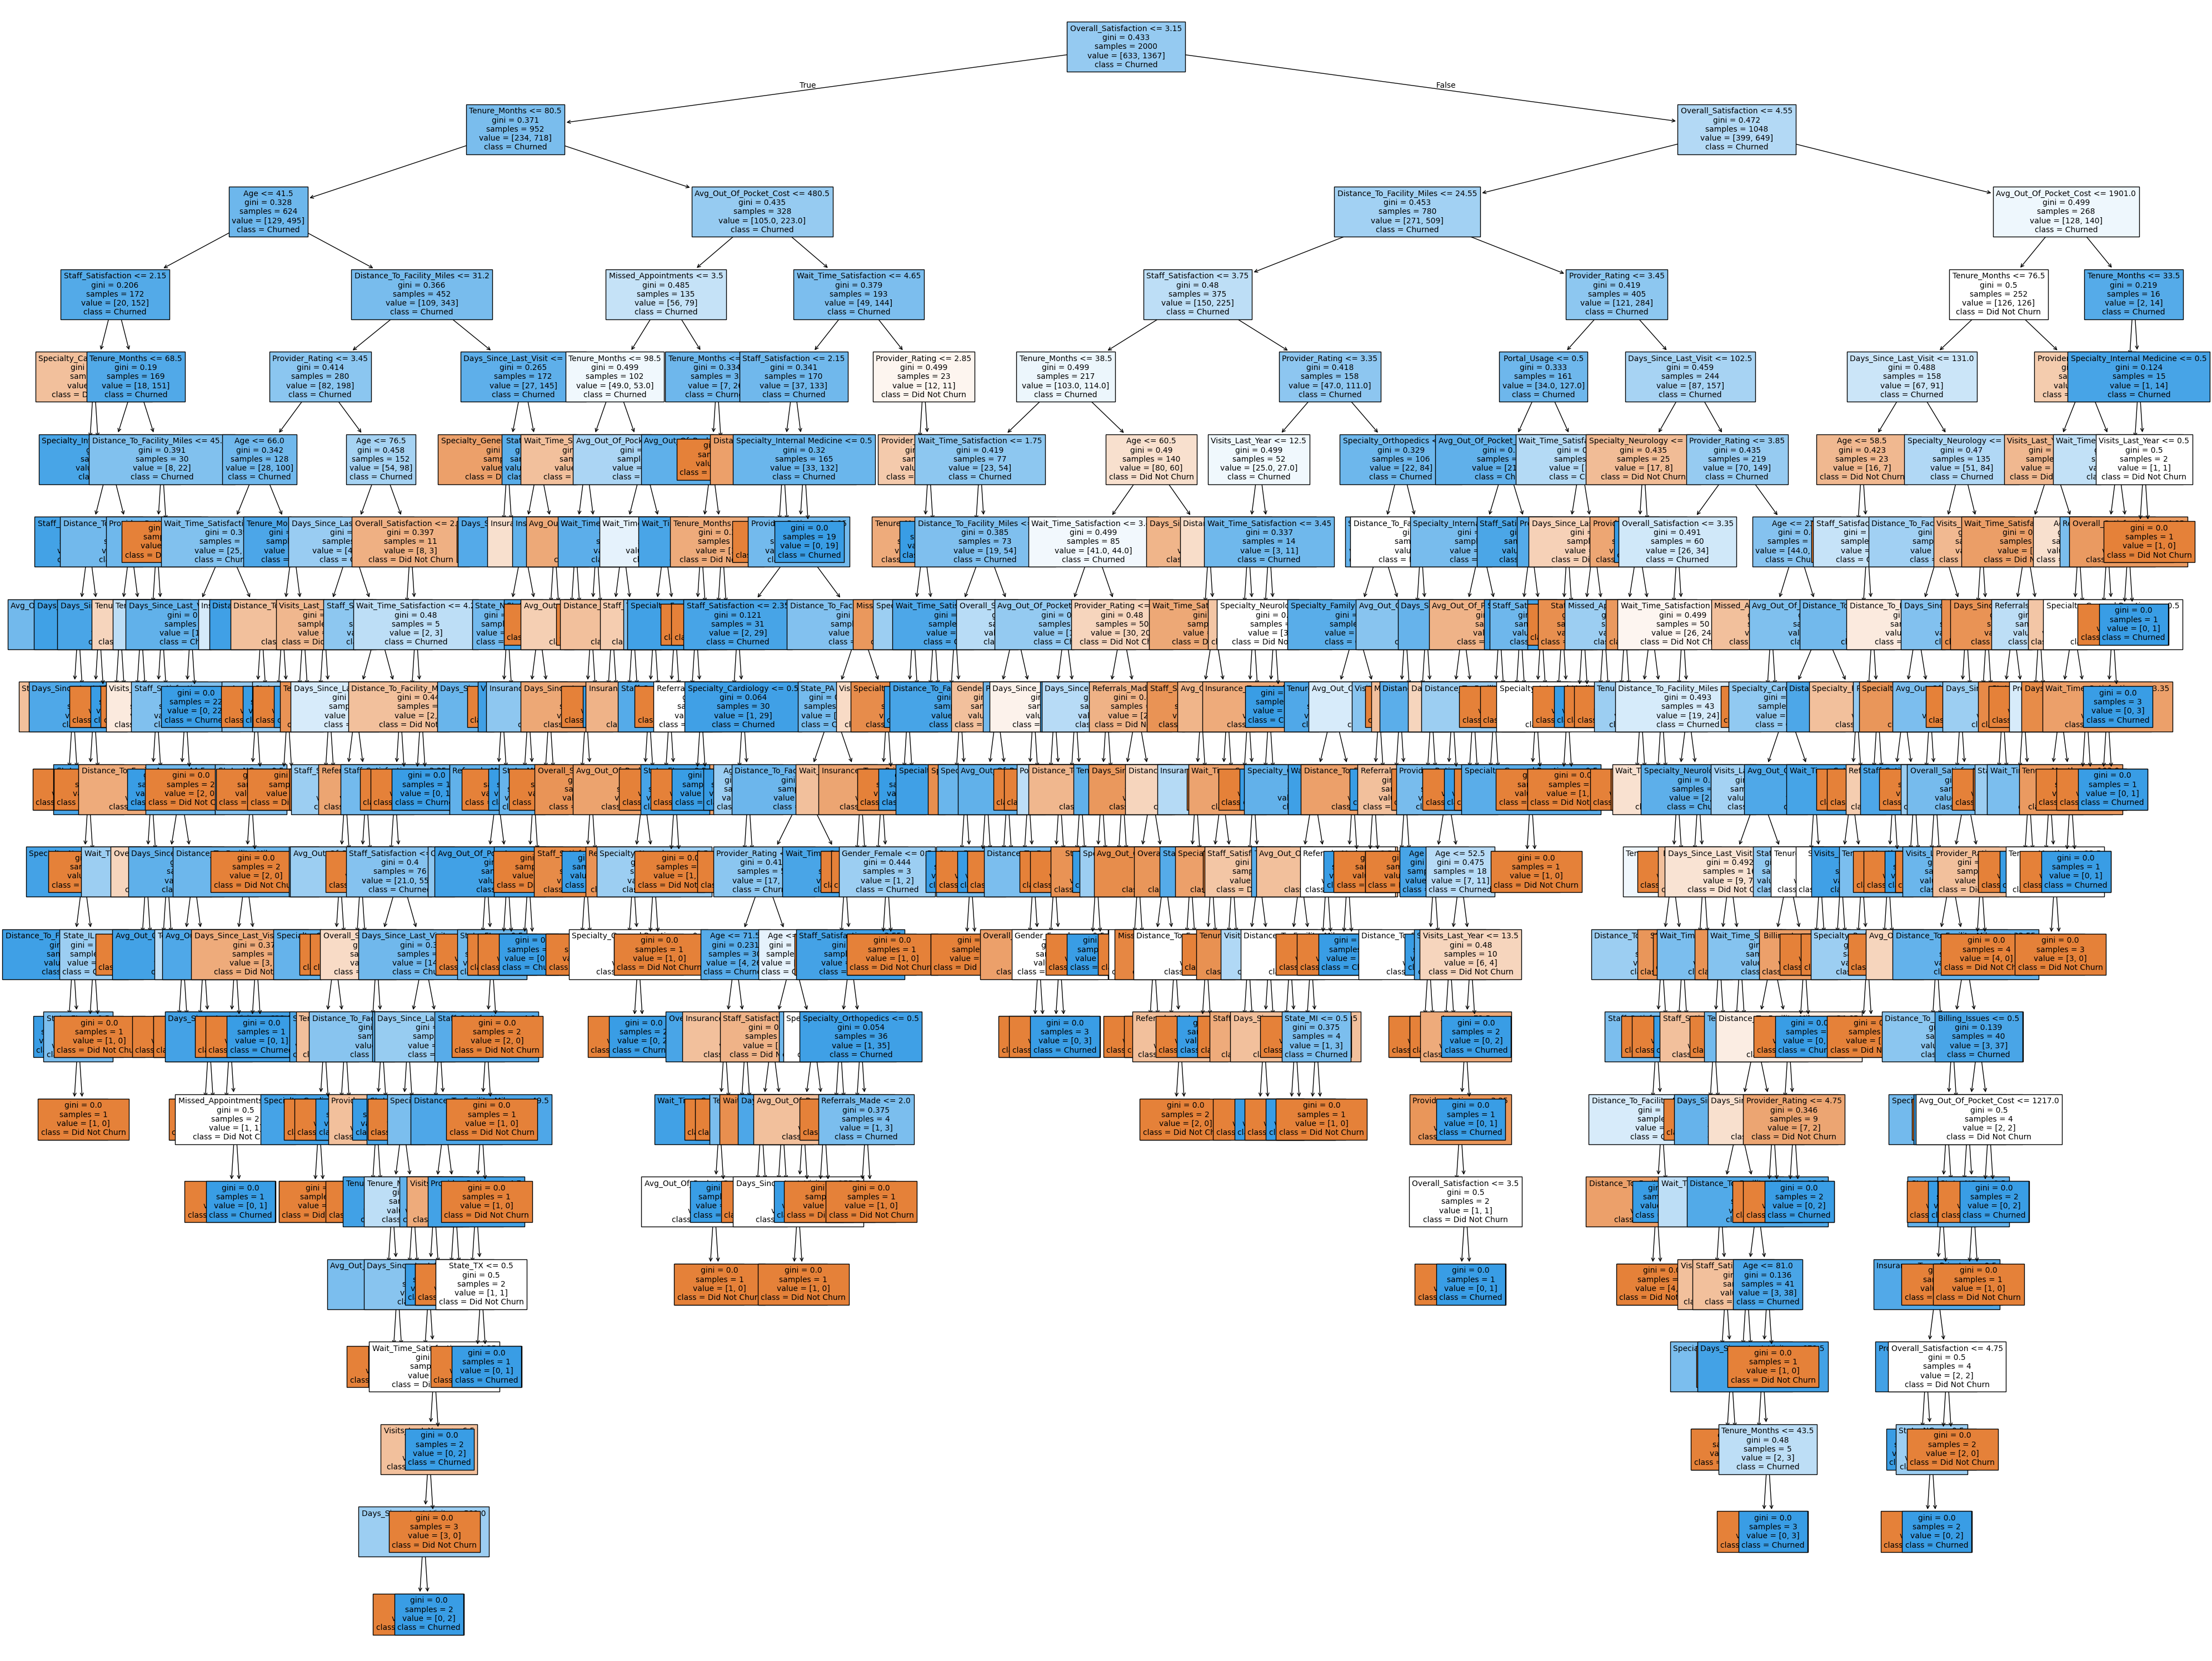

In [46]:
# Display with no depth limit (hyper parameters that would cause overfitting)
# Trees split till we only have one class per node and typically end up with only one sample per node at the leafs, causing heavy overfitting
# We can actually see that these settings match the basic decision tree without setting our own hyperparameters
dt2 = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, criterion="gini", random_state=9)
dt2.fit(X, y)

# Display the Tree
plt.figure("Decision Tree", figsize=(40,30))
plot_tree(dt2, fontsize=10, filled=True, feature_names=X.columns, class_names=["Did Not Churn", "Churned"])
plt.tight_layout()
plt.show()

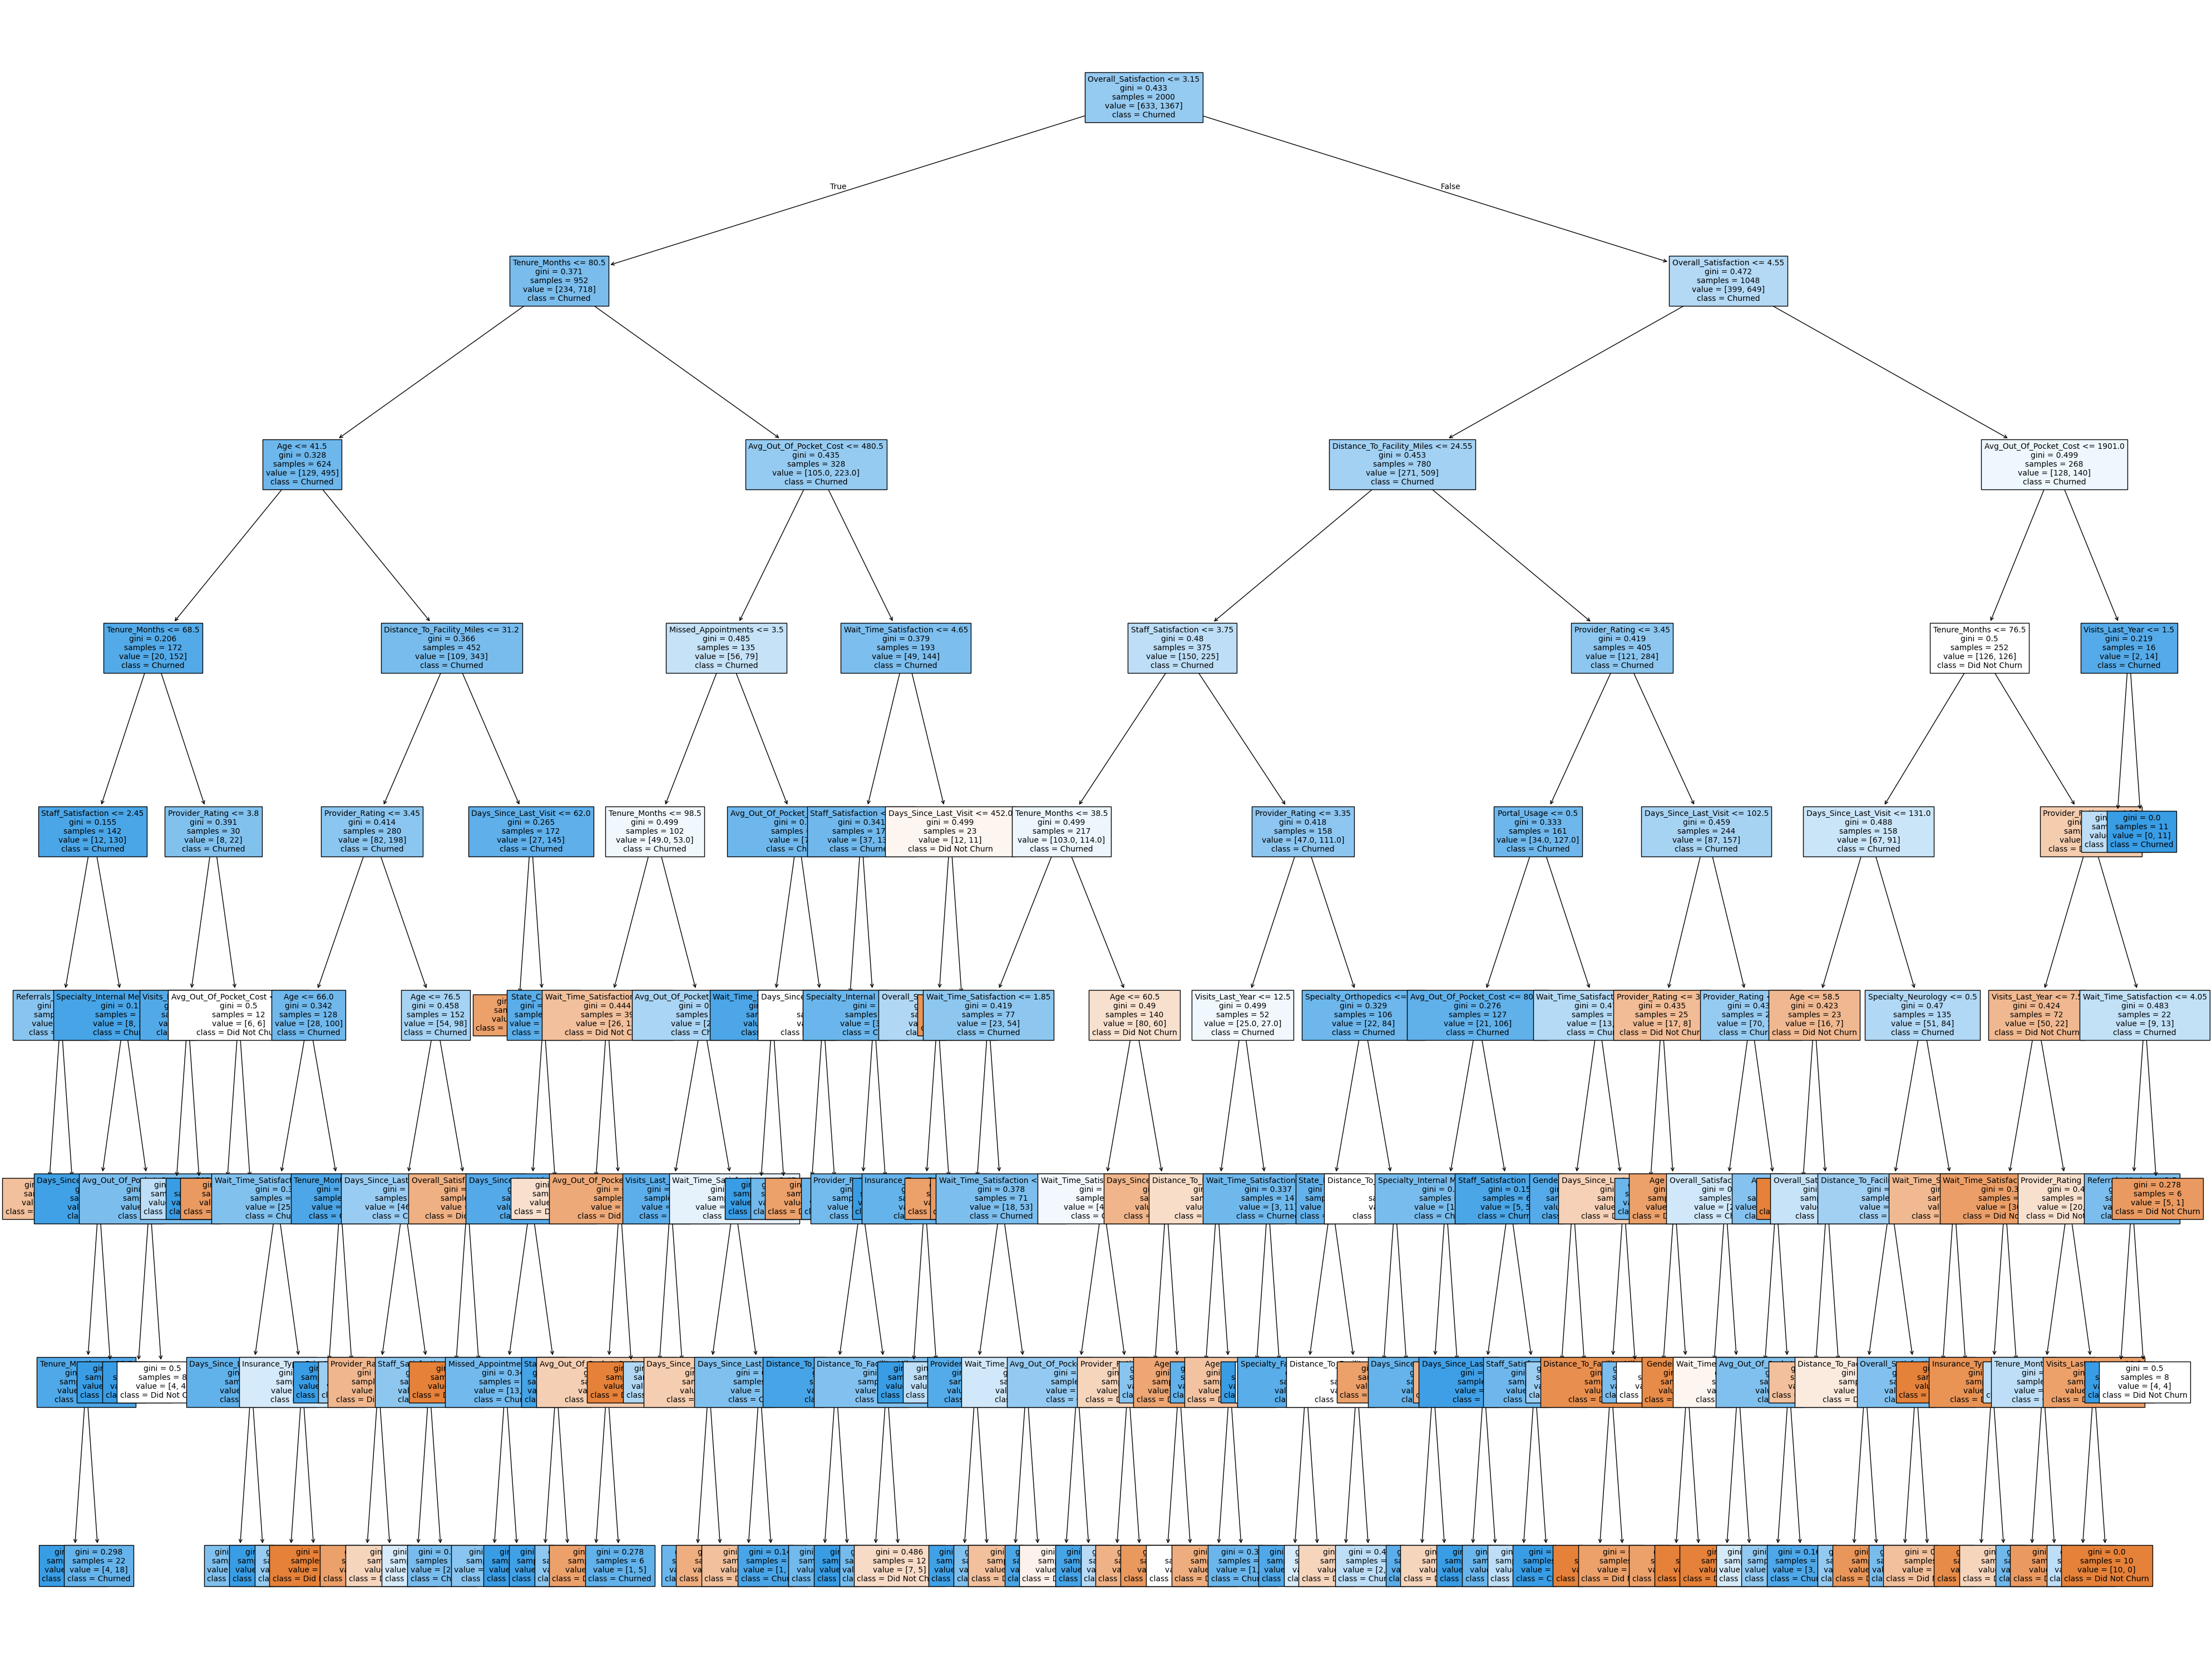

In [47]:
# Display with a max depth of 5 and a minimum number of samples per leaf
# SHould show a tree that is neither underfitting or overfitting hopefully
dt3 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, criterion="gini", random_state=9)
dt3.fit(X, y)

# Display the Tree
plt.figure("Decision Tree", figsize=(40,30))
plot_tree(dt3, fontsize=10, filled=True, feature_names=X.columns, class_names=["Did Not Churn", "Churned"])
plt.tight_layout()
plt.show()

## Comment on how the depth and complexity change the tree

For the shallow tree, we can see that the tree has very few splits and does not capture the patterns in the data as there is not a single leaf node that confidently predicts a churn. The model is very clear to read but it heavily underfits as mentioned above with not being able to make strong predicitions for a churn and having fairly weak predictions of not churning too. (The proportion of churn to not churn in the leaf nodes is close to 1 : 2 or worse for a good amount of leaf nodes). The max_depth parameter determines how complex the trees based on limiting how many splits the tree can make and obviously directly controls the depth.

For the deep tree, we can see that having no max_depth and no minimum amount of samples in a leaf leads to a very deep and complex tree. This leads to the tree being nearly impossible to read and interpret. We can also see that this tree is overfitting as unless a node only has one class in it, the tree keeps splitting until there is only one sample left inside the leaf node. This leads us to see that not constricting max_depth can lead to a lot of overfitting and a very complex tree. Additionally, min_samples_leaf has the same effect in that it allows the tree to keep going deep enough and have decisions that are determined by a single sample which inherently is likely to be noisy and cause a high variance. This shows that a lower min_samples_leaf causes the depth and complexity to be higher.

For the tree with constrained max_depth and constrained min_samples_leaf with reasonable values, we can see that our tree captures complex patterns while avoiding excessive branching due to the min samples and max depth. We can especially see this by looking at the leaf nodes and seeing that they contain multiple samples which means the tree is more stable and theoretically generalizes better. This type of tree is balancing depth and generalization.

As a general overview, increasing tree depth improves the training accuracy but it also increases the complexity and overfitting risk. On the other hand, restricting depth and min leaf size can be seen to improve generalization at the cost of model flexibility (risk of underfitting as seen with the first tree).

## Do some research on what sensitivity analysis is and how it is performed (include citations). Perform a sensitivity analysis to measure the impact of at least two input features on your model's decision boundary.

Sensitivity analysis is a formal technique for studying how changes in the inputs of a model affects the predicitions/outputs of a model. One way of doing this is by pertubbing or moving a singular input while holding the rest. Then you can analyze how it affected your decision. We can personally implement this using a partial dependence plot to see how the feature affects the decision at each decision boundary. This will result in flat decisions except at the decision boundaries where there will be a jump as expected of a tree. This is because any pertubation within a decision boundary will not change its impact as the result is still the same, but if you cross the boundary it will have a different impact on the output.


Sources:
- https://medium.com/@einat_93627/understand-your-black-box-model-using-sensitivity-analysis-practical-guide-ef6ac4175e55
- https://en.wikipedia.org/wiki/Sensitivity_analysis

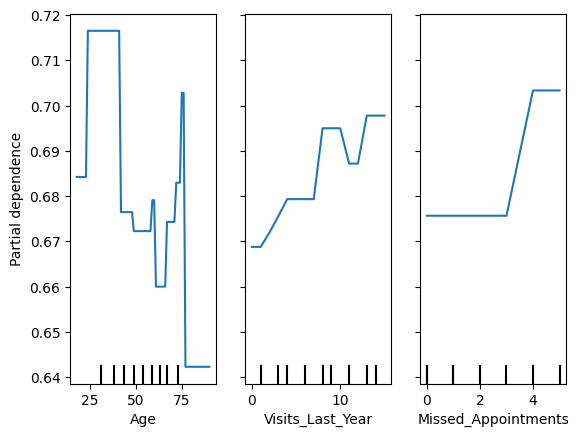

In [48]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    dt3,
    X,
    features=["Age", "Visits_Last_Year", "Missed_Appointments" ],
    kind="average"
)


From out sensitivity analysis we can see that typically age plays a strong role in determining a churn, especially within the 25-35 age range. From there age starts to matter less in the determination of a churn. Visits last year we can see typically goes up in dependence as the number goes up and as we cross the decision boundaries. The Same can be said for missing appointments which strictly goes up in dependance as you increase the number across decision boundaries. The decision boundaries can be seen from where the graph goes from piecewise constant (horizontal line) to jumping down or up to the next piecewise section.

# Task 2 (30 points): From the Bagging and Boosting ensemble methods pick any one algorithm from each category. Implement both the algorithms using the same data.

• Use stratified k-fold cross-validation with at least three different folds (e.g., 5, 10, 15).
You may do your own research on this technique (include citations).

• Evaluate the models using any three-evaluation metrics of your choice (e.g. accuracy,
Precision, F1-score etc.).

• Comment on the behavior of each algorithm under the metrics. Does the performance
ranking change based on the metric used? Why?

Sources:
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
- https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold
- https://www.geeksforgeeks.org/machine-learning/stratified-k-fold-cross-validation/

Stratified Cross validation is a technique used for evaluating a model. It is like k-fold validation but it uses stratification. K-fold cross validation is when you split the data into k partitions. You then train on k-1 partitions and evaluate on the left out partition. You repeat this leaving out every partition to get a good estimate of your error outside the training data while still training on everything. Stratified cross validation is this but it maintains the class distribution present in the original data inside each fold. For example if there was a 70-30 split across classes the folds would try to have the same 70-30 split of the classes within them.



In [59]:
# Define the two models
rf = RandomForestClassifier(random_state=9)
gb = GradientBoostingClassifier(random_state=9)

results_data = []

# Define the metrics we will be scoring/evaluating them with
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, average="macro"),
    "recall": make_scorer(recall_score, average="macro"),
    "F1": make_scorer(f1_score, average="macro"),
}

# Create an array to test number of folds we will be testing
folds = [5, 10, 15]
for n in folds:
  print("Number of Folds =", n)
  # Create a stratified k fold for the number of splits we defined
  skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=9)

  # train and cross validate on the folds
  cv_results = cross_validate(rf, X, y, cv=skf, scoring=scoring, return_train_score=False)
  print("Random Forest (Bagging)")
  for metric, scores in cv_results.items():
    if "test" in metric:
        print(metric, "\n\tScores:", scores, "\n\tAvg:", np.mean(scores))

  # Add to a results table
  results_data.append({
        "Model": "Random Forest",
        "Folds": n,
        "Accuracy": np.mean(cv_results["test_accuracy"]),
        "Precision": np.mean(cv_results["test_precision"]),
        "Recall": np.mean(cv_results["test_recall"]),
        "F1-Score": np.mean(cv_results["test_F1"])
    })

  # train and cross validate on the folds
  print("\nGradient Boosting (Boosting)")
  cv_results = cross_validate(gb, X, y, cv=skf, scoring=scoring, return_train_score=False)
  for metric, scores in cv_results.items():
    if "test" in metric:
      print(metric, "\n\tScores:", scores, "\n\tAvg:", np.mean(scores))

  # Add to a results table
  results_data.append({
        "Model": "Gradient Boosting",
        "Folds": n,
        "Accuracy": np.mean(cv_results["test_accuracy"]),
        "Precision": np.mean(cv_results["test_precision"]),
        "Recall": np.mean(cv_results["test_recall"]),
        "F1-Score": np.mean(cv_results["test_F1"])
    })

  print("\n\n")

# Display table with the results
results_df = pd.DataFrame(results_data)
display(results_df)



Number of Folds = 5
Random Forest (Bagging)
test_accuracy 
	Scores: [0.69   0.7075 0.6675 0.6775 0.6775] 
	Avg: 0.6839999999999999
test_precision 
	Scores: [0.62594532 0.68338136 0.5082897  0.57891705 0.57702592] 
	Avg: 0.5947118682915318
test_recall 
	Scores: [0.525084   0.55714865 0.50164403 0.52370857 0.52160307] 
	Avg: 0.5258376637507622
test_F1 
	Scores: [0.47493225 0.53188297 0.43985259 0.48387097 0.47874049] 
	Avg: 0.4818558544309058

Gradient Boosting (Boosting)
test_accuracy 
	Scores: [0.6825 0.6825 0.6675 0.6725 0.665 ] 
	Avg: 0.6739999999999999
test_precision 
	Scores: [0.59627013 0.6003989  0.5482337  0.59113591 0.55899844] 
	Avg: 0.5790074133132694
test_recall 
	Scores: [0.54104391 0.55176109 0.51638257 0.55794468 0.5271841 ] 
	Avg: 0.538863270951322
test_F1 
	Scores: [0.51944452 0.53931677 0.47801686 0.55271402 0.50377722] 
	Avg: 0.5186538781555615



Number of Folds = 10
Random Forest (Bagging)
test_accuracy 
	Scores: [0.68  0.7   0.67  0.705 0.69  0.67  0.705 0.68  0.65

Model  Folds  Accuracy  Precision    Recall  F1-Score
0      Random Forest      5  0.684000   0.594712  0.525838  0.481856
1  Gradient Boosting      5  0.674000   0.579007  0.538863  0.518654
2      Random Forest     10  0.683000   0.596025  0.525881  0.482996
3  Gradient Boosting     10  0.674500   0.585627  0.537932  0.516766
4      Random Forest     15  0.682527   0.604825  0.523864  0.478725
5  Gradient Boosting     15  0.667991   0.562017  0.534017  0.512631

## Comment on the behavior of each algorithm under the metrics. Does the performance ranking change based on the metric used? Why?

Across all fold values, Random forest consistently had higher accuracy and precision that the Gradient Boosting method. The random forest model focuses on reducing variance thus increasing the overall accuracy. This in turn benefits the precision metric as random forest produces less false positives (by reducing variance) and thus the precision goes up. On the other hadn, gradient boosting had higher recall and f1-scores. This makes sense as gradient boosting focuses on fixing errors and therefore it does better identifying the minority or hard to classify cases during training. This means that it has a higher chance to predict more positives (a minority class) which benefits recall as it gets hurt by missing positive classifications. This is what results in having better recall than the random forest model, but it results in increased false positives which is why it does worse in accuracy and precision. In regards to f1-score because gradient boosting's gain in recall is bigger than random forest's gain in precision/gradient boosting's loss in precision, the f1-score leans to gradient boosting as it evaluates a mix of the two.

# Task 3 (40 points): Compare the effectiveness of the three models implemented above. Analyze the results using the following:
• A confusion matrix for one selected test fold.

• A statistical test (e.g., paired t-test) to determine if differences between models are
significant.

• A discussion on the trade-off between bias and variance for each model.

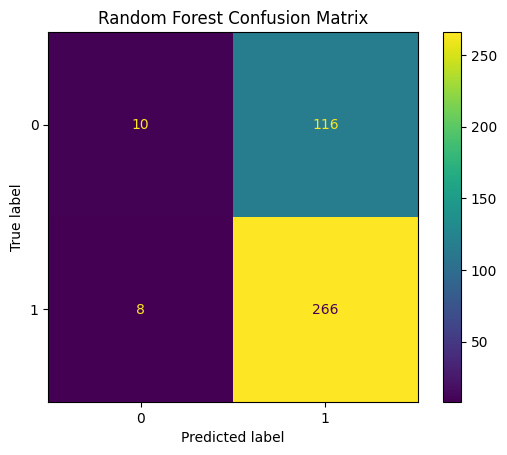

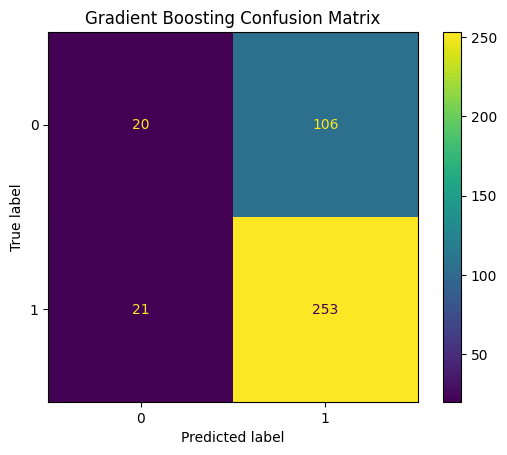

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Select the first fold from 5 fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)
train_index, test_index = next(skf.split(X, y))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Fit both models on the training fold
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_pred_gb = gb.predict(X_test)

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

# Confusion Matrix for Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
disp_gb.plot()
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

In [66]:
from scipy.stats import ttest_rel

# Define models again
rf = RandomForestClassifier(random_state=9)
gb = GradientBoostingClassifier(random_state=9)
scoring = {
    "accuracy": make_scorer(accuracy_score)
}

# Stratified 10-fold CV
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=9)

# Random Forest CV
cv_results_rf = cross_validate(rf, X, y, cv=skf, scoring=scoring, return_train_score=False)
print("Random Forest (Bagging) 10-Fold CV")
for metric, scores in cv_results_rf.items():
    if "test" in metric:
        print(metric, "\n\tScores:", scores, "\n\tAvg:", np.mean(scores))

# Gradient Boosting CV
cv_results_gb = cross_validate(gb, X, y, cv=skf, scoring=scoring, return_train_score=False)
print("\nGradient Boosting (Boosting) 10-Fold CV")
for metric, scores in cv_results_gb.items():
    if "test" in metric:
        print(metric, "\n\tScores:", scores, "\n\tAvg:", np.mean(scores))
print("\n")

# Do the t-test with the accuracy values
t_stat, p_value = ttest_rel(cv_results_rf["test_accuracy"], cv_results_gb["test_accuracy"])
print(f"Paired t-test (10-fold accuracy): t={t_stat:.4f}, p={p_value:.4f}")




Random Forest (Bagging) 10-Fold CV
test_accuracy 
	Scores: [0.68  0.7   0.67  0.705 0.69  0.67  0.705 0.68  0.655 0.675] 
	Avg: 0.683

Gradient Boosting (Boosting) 10-Fold CV
test_accuracy 
	Scores: [0.67  0.685 0.64  0.695 0.675 0.67  0.695 0.675 0.64  0.7  ] 
	Avg: 0.6745


Paired t-test (10-fold accuracy): t=1.8993, p=0.0900


## Statistical T-test

When testing the accuracy scores with a t-test we can see that we get a p value of 0.09. Because we need a p value less than 0.05 to say that the difference is statistically significant, we can say that the difference in accuracy between the models is not significant.

## Bias and Variance trade-off discussion

Both Boosting and Bagging models attempt to improve upon the results of a singular decision tree by aggregating the results of multiple models. Random Forest is a bagging model meanwhile Gradient Boosting is a boosting model. Bagging Models are models that train multiple trees on subsets of the data in parallel. This is done in an effort to reduce the variance in the final decisions/outputs. On the other hand Gradient Boosting models train trees in a successive fashion where they attempt to fix the mistakes that the previous model had made. This works to reduce the bias in the model by fixing mistakes within the training data.

For random forest, variance is reduced by trying to averaging multiple of these trees. This makes the bagging model less likely to overfitt, but it comes with the risk of slighlty reducing bias due to not training each tree fully on the data.

Gradient Boosting can on the other hand increase the chance for overfitting and therefore increase the variance. This is because it focuses on the instances that the model gets wrong and therefore the model can focus too much on those entries and overfit.

With this in mind, we can see that there is a tradeoff between variance and bias between the two models. Gradient boosting priotizes bias but slightly sacrifcies precision, while bagging prioritizes variance while slightly sacrificing bias. Going further, random forest/bagging focuses on stability which is the low variance by focusing on majority class accuracy meanwhile gradient boosting focuses on correcting errors, which makes it more sensitive to noise. As seen by our results, the choice of model depends on whether accuracy/precision is more important to your goal or if recall/f1-score is more important as the models have different implications for these evaluation metrics and do better on particular ones than the others.